# Preconscious Augmentation

This script trains the classifier for a brain-computer interface that controls electrical muscle stimulation in the preconscious augmentation experiment.
The functions used to build the feature vectors are the same that are used for the online application and are found in 'bci_funcs'

A two class linear discriminant model is fitted to idle and pre-movement EEG training data. The model and a channel selection is saved.


In [45]:
pID = 3
pID = 'sub-0' + "%02d" % (pID)

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, KFold
import pickle
import scipy.io
from bci_funcs import windowed_mean, base_correct, drop_baseline
import mne

#path = '/Users/lukasgehrke/Documents/publications/2021-fastReach/data/study/eeglab2python/'
# path = 'P:\\Lukas_Gehrke\\2021-fastReach\\data\\study\\eeglab2python\\'
path = '/Volumes/projects/Lukas_Gehrke/2021-fastReach/data/study/eeglab2python/'

In [47]:
pre_move = scipy.io.loadmat(path+pID+'/pre_move.mat')
idle = scipy.io.loadmat(path+pID+'/idle.mat')
chans = np.array(pd.read_csv(path+pID+'/sel_chans.csv', header=None)).flatten()
chans = chans - 1 # Matlab to python indexing

filename = path+pID+'/chans_'+pID+'_eeg.sav'
pickle.dump(chans, open(filename, 'wb'))

windows = 11
baseline_ix = 1

idle = idle['idle'][chans,:,:]
pre_move = pre_move['pre_move'][chans,:,:]

idle_means = np.zeros((idle.shape[2], idle.shape[0] * (windows-baseline_ix)))
pre_move_means = np.zeros((pre_move.shape[2], pre_move.shape[0] * (windows-baseline_ix)))

for trial_ix in range(0, pre_move.shape[2]):
    tmp = base_correct(windowed_mean(pre_move[:,:,trial_ix], windows = windows))
    pre_move_means[trial_ix, :] = drop_baseline(tmp, baseline_ix).flatten()

for trial_ix in range(0, idle.shape[2]):
    tmp = base_correct(windowed_mean(idle[:,:,trial_ix], windows = windows))
    idle_means[trial_ix, :] = drop_baseline(tmp, baseline_ix).flatten()

data = np.concatenate((pre_move_means, idle_means), axis = 0)

In [48]:
pre_move_class = np.ones((pre_move_means.shape[0], 1))
idle_class = np.zeros((idle_means.shape[0], 1))
classes = np.concatenate((pre_move_class, idle_class)).ravel()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

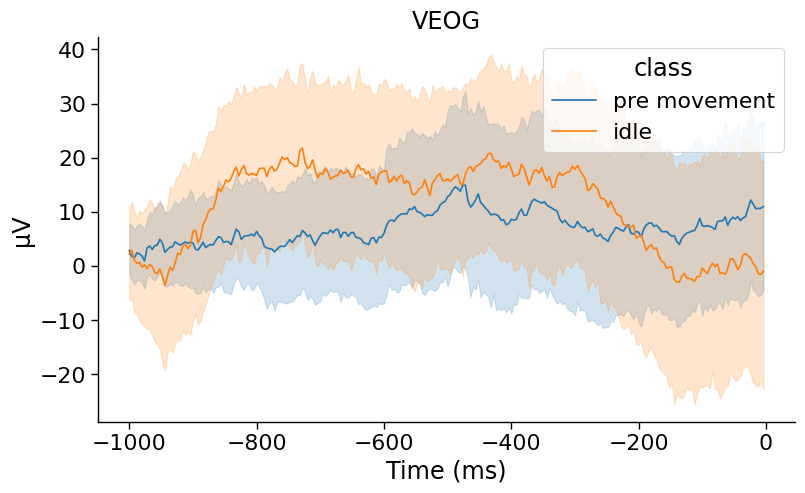

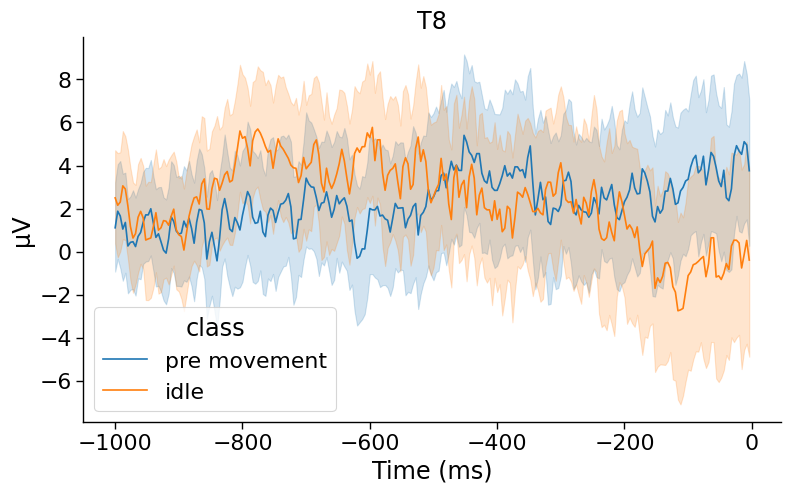

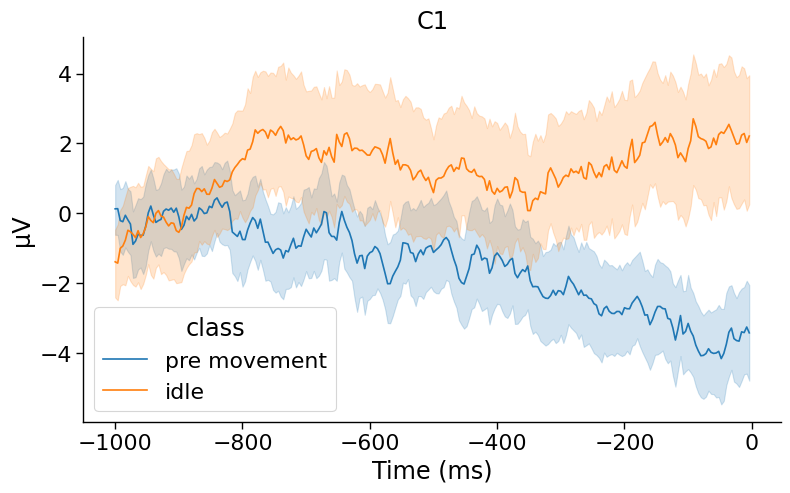

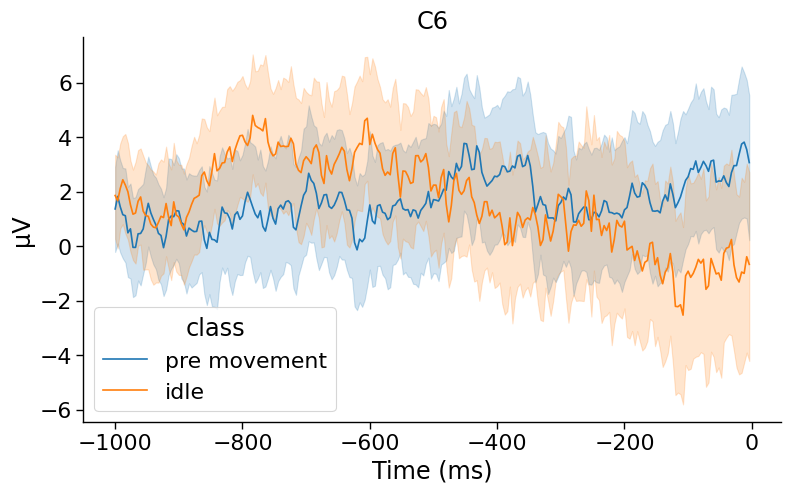

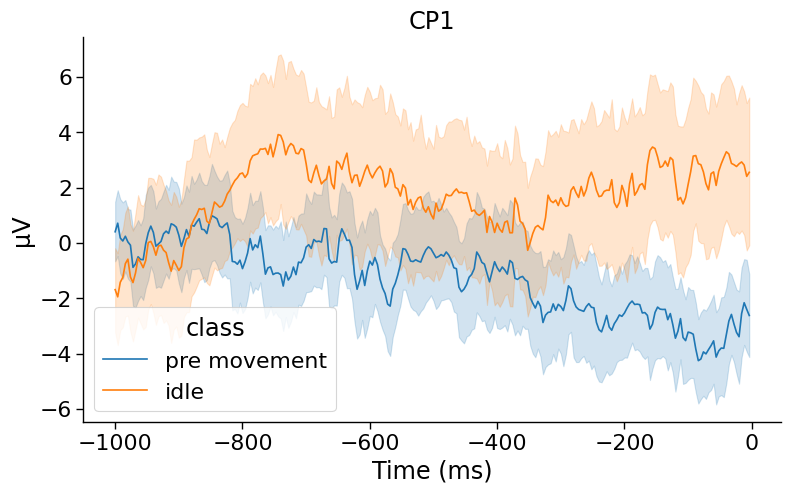

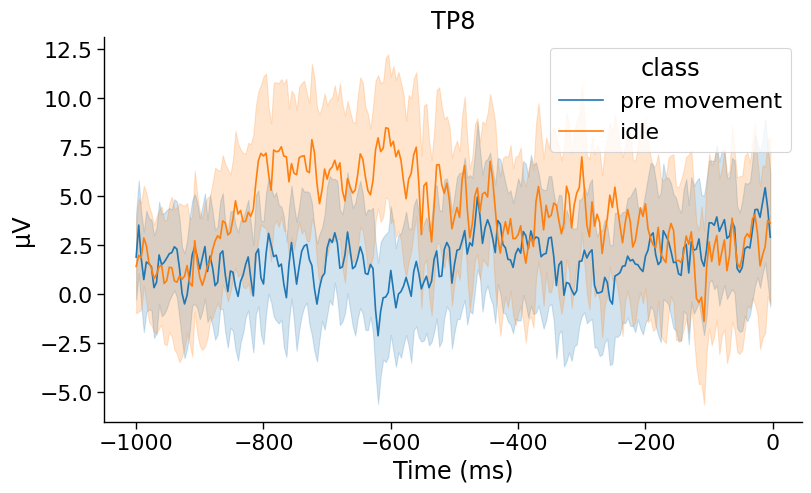

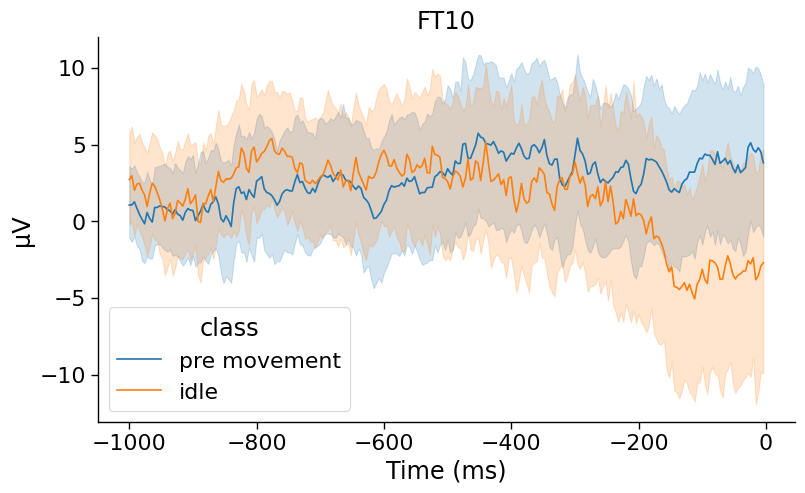

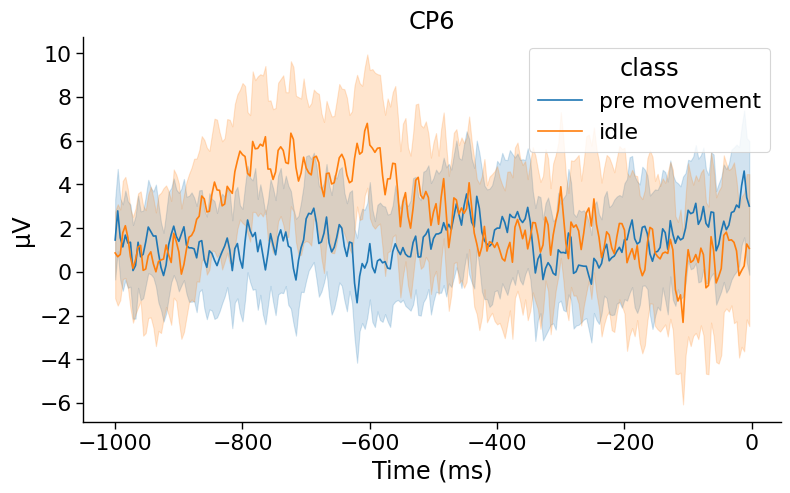

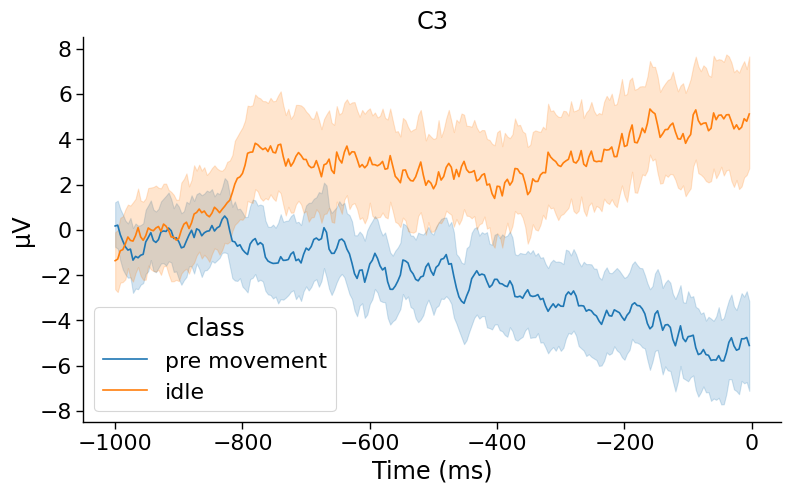

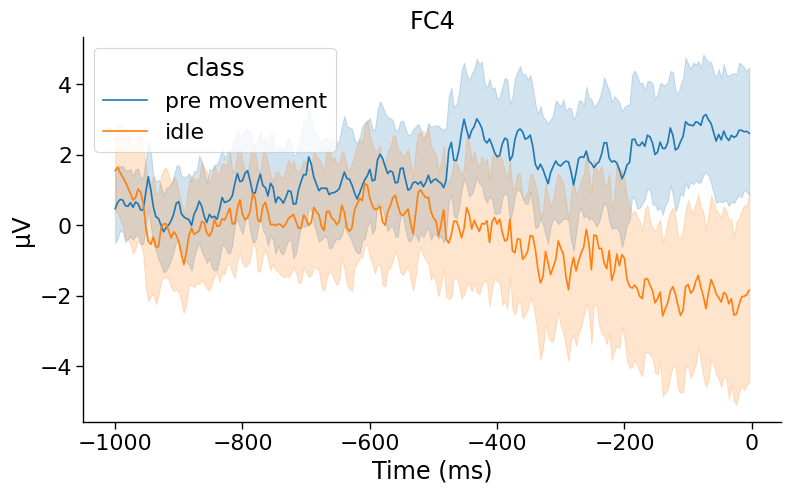

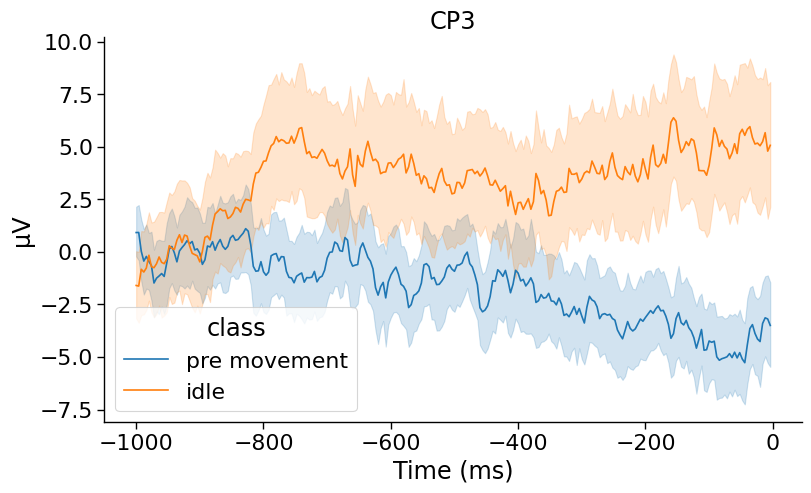

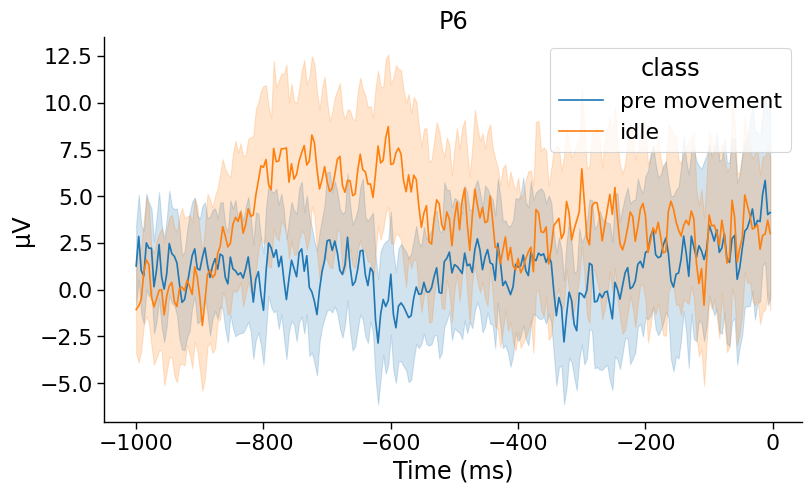

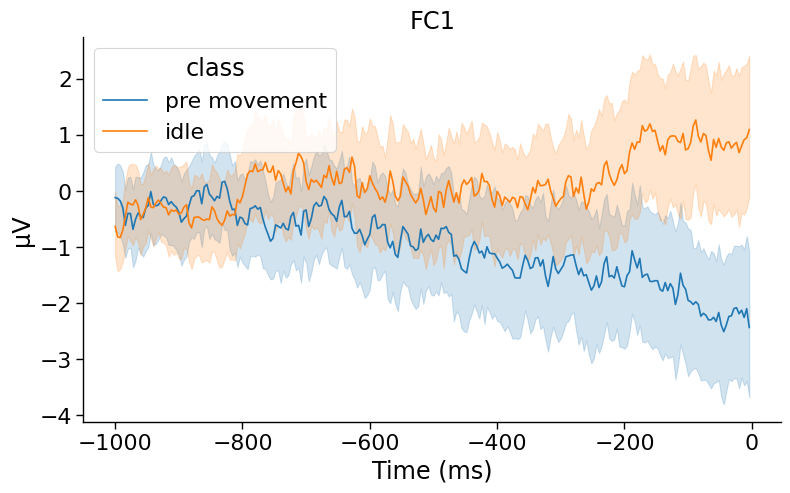

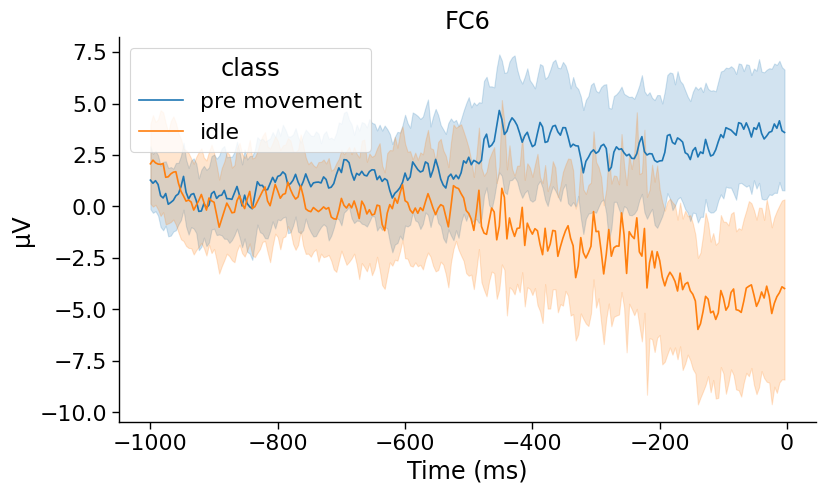

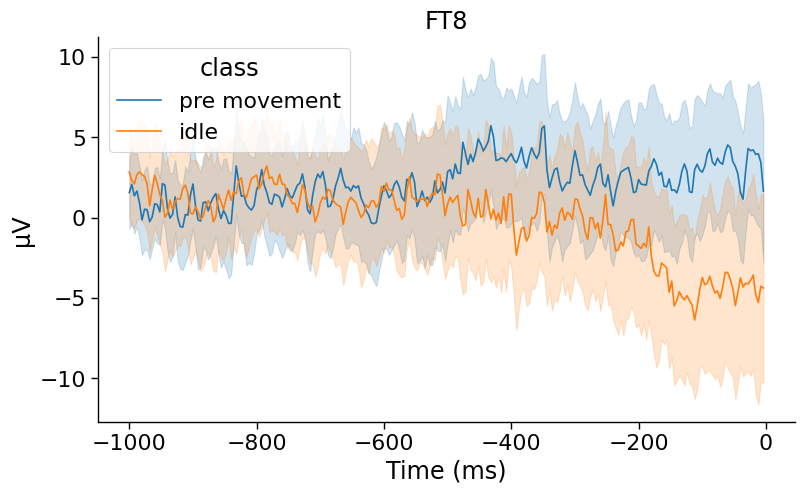

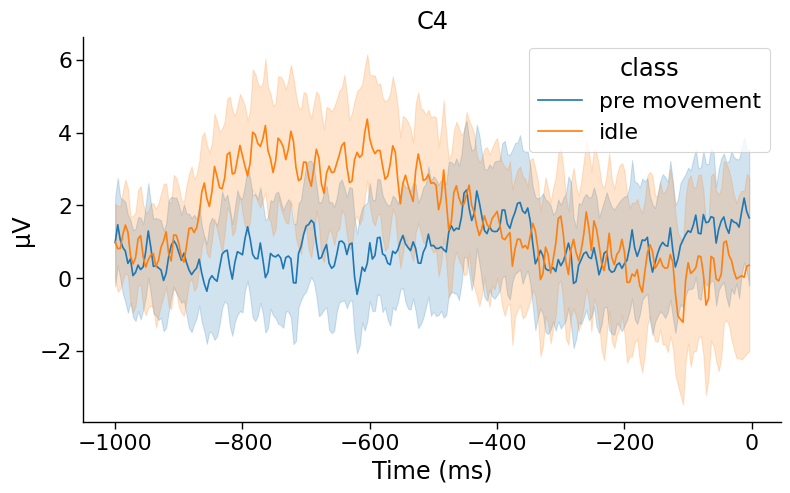

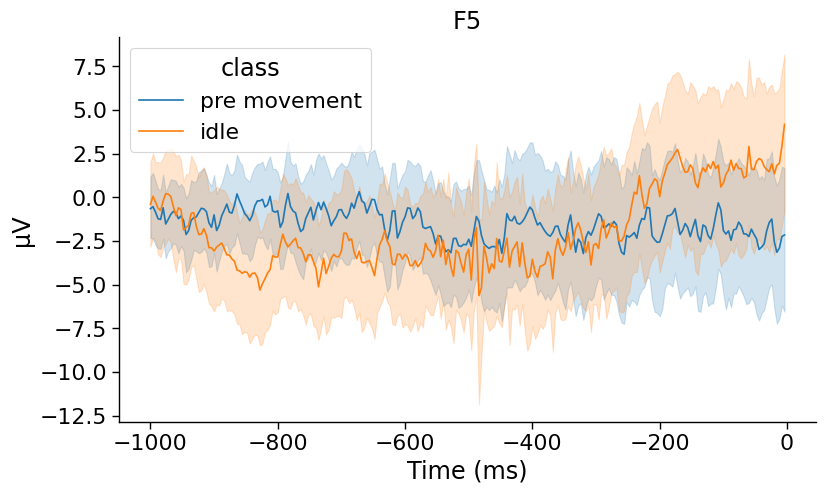

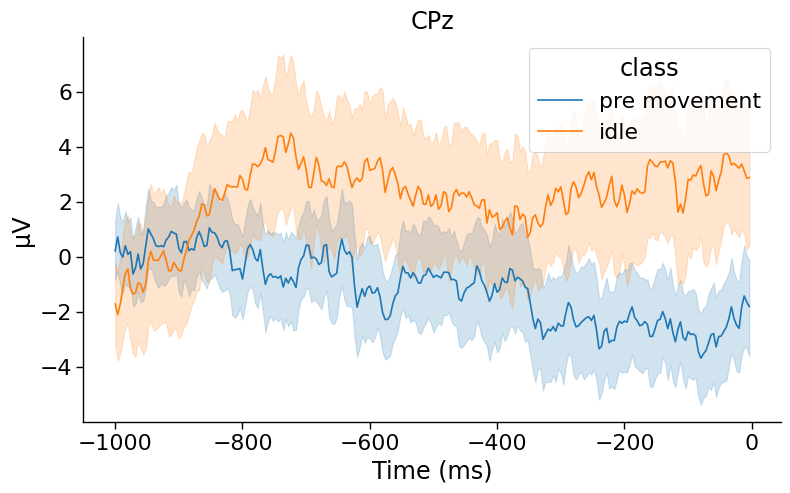

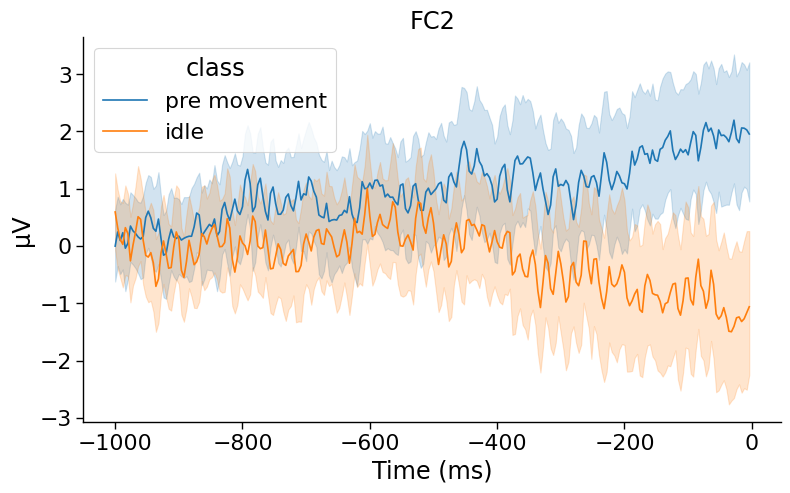

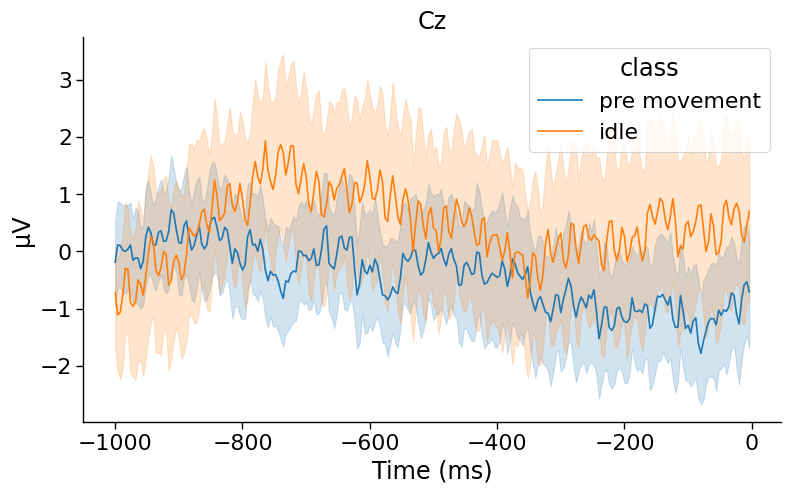

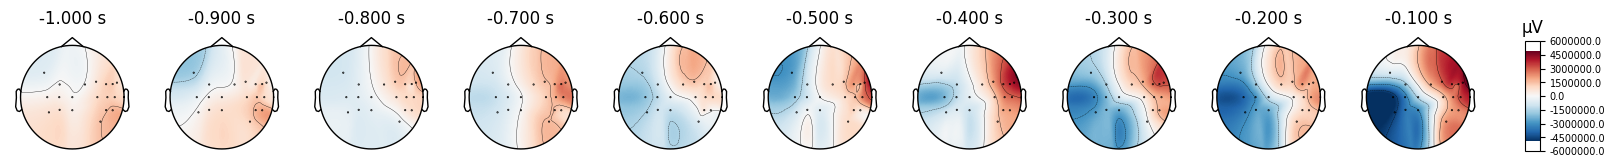

In [49]:
# save plots individual participants
chans_names = pd.read_csv(path+pID+'/sel_chans_names.csv')

# erp
for c_ix in range(0, len(chans)):
        
    idle_cz = idle[c_ix,:,:] - np.mean(idle[c_ix,:24,:], axis = 0)
    pre_move_cz = pre_move[c_ix,:,:] - np.mean(pre_move[c_ix,:24,:], axis = 0)

    pre_move_cz = pd.DataFrame(pre_move_cz[25:,:].T)
    idle_cz = pd.DataFrame(idle_cz[25:,:].T)
    condition = pd.DataFrame(classes, columns=['class']).astype('string')
    condition['class'].replace({'0.0': 'idle', '1.0': 'pre movement'}, inplace=True)

    erp = pd.concat([pre_move_cz, idle_cz], axis=0).reset_index(drop=True)
    erp_class_cz = pd.concat([condition['class'], erp], axis=1)

    with sns.plotting_context('paper', font_scale = 1.8):
        fig, ax = plt.subplots(1, 1, figsize=(9,5))
        fig.patch.set_alpha(1)
        sns.despine() #bottom=True, left=True 

        data_long = pd.melt(erp_class_cz, id_vars='class', var_name='timepoint', value_name='µV', col_level=None, ignore_index=True)

        # adjust time axis
        data_long['timepoint'] = (((1/250) * (data_long["timepoint"].astype(int)))*1000) - 1000

        # plot
        ax = sns.lineplot(data = data_long, x = 'timepoint', y = 'µV', hue = 'class')
        ax.set(xlabel='Time (ms)', ylabel='µV', title=chans_names.Var1[chans[c_ix]])

        fig.savefig(path + pID + '/' + chans_names.Var1[chans[c_ix]] + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig(path + pID + '/' + chans_names.Var1[chans[c_ix]] + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

# features, for one channel?

# scalp topographies
channel_labels = chans_names['Var1'].values.tolist()
channel_labels = channel_labels[0:-1]
eog_ix = channel_labels.index('VEOG')
chans_types = ['eeg'] * channel_labels.__len__()
chans_types[eog_ix] = 'eog'
info = mne.create_info(channel_labels, ch_types=chans_types, sfreq=250)
easycap_montage = mne.channels.make_standard_montage('easycap-M1')

pre_move = scipy.io.loadmat(path+pID+'/pre_move.mat')
pre_move = pre_move['pre_move'].mean(axis=2)
pre_move = pre_move.T - pre_move[:,0:24].mean(axis=1)
pre_move = pre_move[24:,:].T

raw = mne.EvokedArray(pre_move, info, tmin=-1)
raw.set_montage(easycap_montage)

raw.pick_channels(chans_names.Var1[chans].values.tolist())

times = np.arange(-1, 0, 0.1)
fig = raw.plot_topomap(times, ch_type='eeg', time_unit='s', show_names=False)
fig.savefig(path + pID + '/topomap_pre_move.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
fig.savefig(path + pID + '/topomap_pre_move.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

In [50]:
clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(data, classes)
print(clf.coef_.shape)

kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
print(cv_results.mean())
print(cv_results.std())

filename = path+pID+'/model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))

(1, 200)
0.7588669950738917
0.04724571963398037


/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

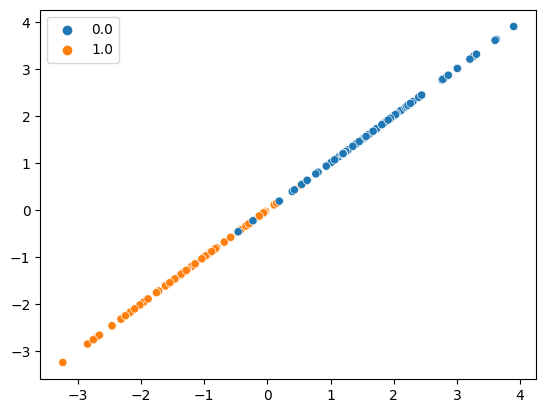

In [51]:
lda_scores = clf.transform(data)
sns.scatterplot(lda_scores[:,0], lda_scores[:,0], hue=classes)